# Notebook 1: From-scratch approach

## Downloading the dataset
The dataset is around 1.23GB. It can be found at:
https://www.kaggle.com/datasets/ninadaithal/imagesoasis/data

If your current environment has a Kaggle API JSON file with a Kaggle access token, you can use the following line to download it.

In [ ]:
# !kaggle datasets download -d ninadaithal/imagesoasis

### For Google Colab Instances:

You can use the upload feature to add your kaggle.json to your Colab instance. The first cell adds a "Choose file..." button at the output. The second moves the kaggle.json file to the ~/.kaggle/ folder, which is where the kaggle API looks for it.

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Download and extract

*Make sure you have sufficient space* for both the zip and the uncompressed files!

In [ ]:
!kaggle datasets download -d ninadaithal/imagesoasis
!unzip imagesoasis.zip

## Import dataset and EDA

The dataset contains 4 directories filled with .jpg images, each corresponding to a brain MRI slice, with multiple slices per patient. As with any classification problem, it is important to better understand the structure of the dataset. The following cell obtains the class counts for the dataset.

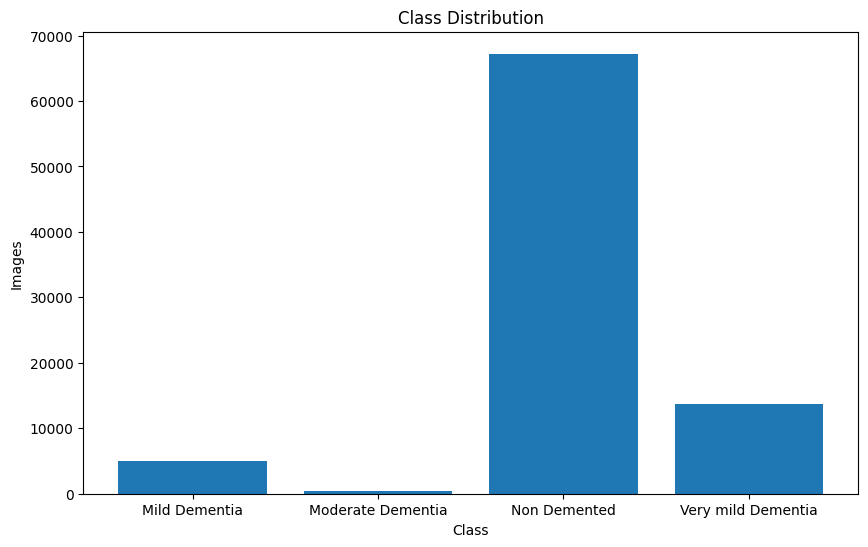

{'Mild Dementia': 5002, 'Moderate Dementia': 488, 'Non Demented': 67222, 'Very mild Dementia': 13725}
Sample image:  Data/Non Demented/OAS1_0234_MR1_mpr-4_147.jpg
Dimensions:  (496, 248)
Mode:  RGB


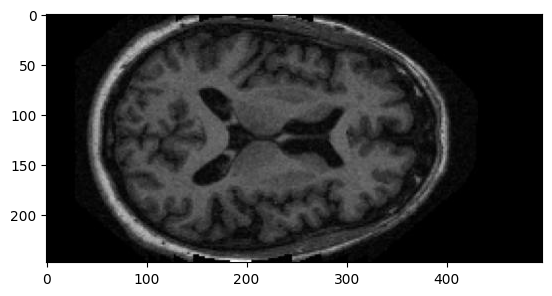

In [4]:
import os
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

# Path to dataset
dataset_path = 'Data'

# Construct image list
all_images = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.jpg'):
            all_images.append(os.path.join(root, file))

# Extract patient IDs and class labels from filenames

patient_ids = [os.path.basename(img).split('_')[1] for img in all_images]
class_labels = [os.path.basename(os.path.dirname(img)) for img in all_images]

# Construct a dictionary with class counts
class_counts = {cls: class_labels.count(cls) for cls in np.unique(class_labels)}

# EDA
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Images')
plt.title('Class Distribution')
plt.show()

print(class_counts)

with Image.open(all_images[0]) as example:
  plt.imshow(example)
  print('Sample image: ', all_images[0])
  print('Dimensions: ', example.size)
  print('Mode: ', example.mode)

Initial EDA shows significant imbalance between classes.
A combination of strategies is necessary. To preserve computational budget, we will refrain from using data augmentation. Undersampling can lead to data loss while oversampling might lead to bias. Instead, we will compromise and use **class weights** to get the model to pay special attention to the underrepresented classes when training.

**It is very common** to see ML projects on neural imaging **making the mistake of pooling images from all patients together** and randomly splitting them into train/test sets as usual. As Yagis et al have documented in multiple papers [[1](https://doi.org/10.1109/BIBM47256.2019.8983088), [2](https://doi.org/10.1038/s41598-021-01681-w)], this practice leads to data leakage between set splits. To obtain relevant results, there must be independence between the splits. If a patient's scan is present in both sets, there will be a high correlation between them and lead to an artificial increase in performance.

To improve upon them we will also perform a **subject-level split** (images will be grouped by patient).

In [5]:
# Perform a grouped train/test split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=1337)
train_idx, test_idx = next(gss.split(all_images, groups=patient_ids))

train_images = np.array(all_images)[train_idx]
test_images = np.array(all_images)[test_idx]

label_dict = {label: i for i, label in enumerate(np.unique(class_labels))}
numeric_labels = [label_dict[label] for label in class_labels]
string_labels = [list(label_dict.keys())[list(label_dict.values()).index(label)] for label in numeric_labels]

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(numeric_labels),
    y=numeric_labels)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

## Model architecture

Because we're building a model from scratch, we will use Sequential from Keras to define the model architecture and compile it.

The dataset has considerable size, so we will also use ImageDataGenerator to create batches of image data instead of loading it all into memory.

Hidden layers will use ReLU activation while the final layer will use a softmax function, which is suitable for multi-class tasks like this one.

To mitigate overfitting, our strategy will be to use Dropout and BatchNormalization to provide regularization to the training. We'll also add Early Stopping as a great strategy to prevent overfitting and minimize training time.

### Hyperparameters and other values

LeCun once [tweeted](https://twitter.com/ylecun/status/989610208497360896): "Friends dont(sic) let friends use minibatches larger than 32."

We've previously tried 16, with less-than-ideal results. We'll try 32 this time, which will make the model converge potentially slower but with a more accurate loss estimate at each step.

In [12]:
img_width, img_height = 496, 248

nb_train_samples = len(train_images)
nb_validation_samples = len(test_images)
epochs = 20
batch_size = 32

### Building model

In [7]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.metrics import AUC
import pandas as pd

In [14]:
# Ensure correct input format
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Layer sequence
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=input_shape, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), input_shape=input_shape, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(4))
model.add(Activation('softmax'))


### Compiling the model

Categorical cross-entropy is an adequate loss function for the model.

Accuracy is often the most convenient metric, but it can't be used for datasets with imbalanced classes. Instead, we'll use AUROC, which shows how good the model is at differentiating between classes.

We'll use ADAM method as the optimizer because it's adaptive and computationally efficient, making it suitable for a wide range of tasks.

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.AUC(name='auc')])


## Training

In [16]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)


# Construct dataframe and splits
data = pd.DataFrame({
    'filename': all_images,
    'class': string_labels
})

train_data = data.iloc[train_idx]
test_data = data.iloc[test_idx]

# Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


Found 69418 validated image filenames belonging to 4 classes.
Found 17019 validated image filenames belonging to 4 classes.


In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
    )


Epoch 1/20
1084/1084 [==============================] - 481s 435ms/step - loss: 0.8609 - auc: 0.7911 - val_loss: 0.7381 - val_auc: 0.9167
Epoch 2/20
1084/1084 [==============================] - 460s 424ms/step - loss: 0.3939 - auc: 0.9376 - val_loss: 1.0164 - val_auc: 0.9014
Epoch 3/20
1084/1084 [==============================] - 463s 427ms/step - loss: 0.2098 - auc: 0.9764 - val_loss: 1.1362 - val_auc: 0.8946
Epoch 4/20
1084/1084 [==============================] - 483s 445ms/step - loss: 0.2527 - auc: 0.9756 - val_loss: 1.0616 - val_auc: 0.8899
Epoch 5/20
1084/1084 [==============================] - 456s 421ms/step - loss: 0.1258 - auc: 0.9898 - val_loss: 1.3116 - val_auc: 0.8769
Epoch 6/20
1084/1084 [==============================] - 463s 427ms/step - loss: 0.0928 - auc: 0.9944 - val_loss: 1.4165 - val_auc: 0.8792
Epoch 6: early stopping


## Evaluate model metrics

We will plot loss and AUC over time.

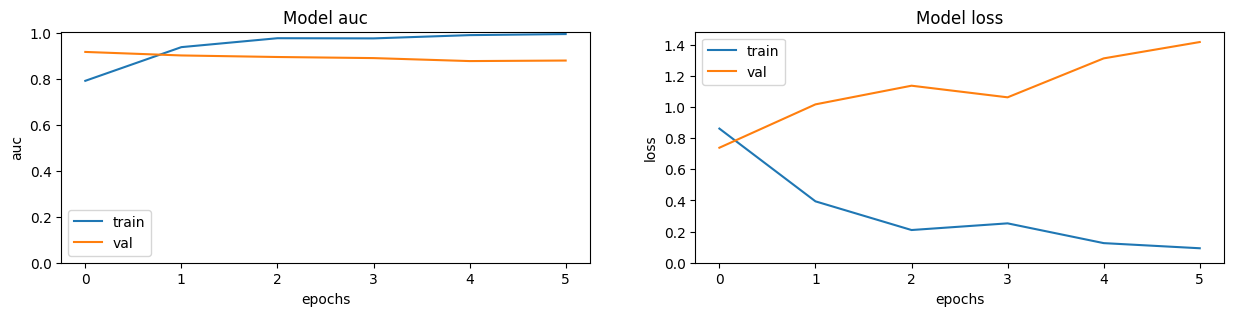

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ax = ax.ravel()

for epoch, metric in enumerate(['auc', 'loss']):
    ax[epoch].plot(history.history[metric])
    ax[epoch].plot(history.history['val_' + metric])
    ax[epoch].set_title('Model {}'.format(metric))
    ax[epoch].set_xlabel('epochs')
    ax[epoch].set_ylabel(metric)
    ax[epoch].legend(['train', 'val'])
    ax[epoch].set_ylim(bottom=0)

The model began to overfit after the first epoch, which is why early stopping kicked in place after 5 epochs of no improvement.

AUC of 0.9167 was achieved. Considering Yakis' findings on [ the average inflation in performance of 26%](https://) for the classification of the diseases when  studies that perpetuate the mistakes in data division (shuffling images instead of patients) which this notebook has avoided , this model is much more likely to be performant at generalization when faced with new data.

The main weakness in this work is the dataset, its imbalance has proven difficult to work on, and leads to the model overfitting instead of improving its accuracy later on.

In future versions, I would love to implement data augmentation on the dataset, introducing rotations, shears, and flips to improve the model's generalization performance. The computing budget on free Google Colab isn't sufficient to achieve this in real-time.


## Save model

The cell below is for saving the model and downloading it from the colab instance and into your computer.

In [20]:
import shutil


model_save_path = "/content/alzheimers"
model.save(model_save_path)

# Zip
shutil.make_archive("/content/alzheimers", 'zip', model_save_path)

# Download
#files.download("/content/alzheimers.zip")

'/content/alzheimers.zip'

## Using the model

Usage: like other models saved using tf/keras' model.save(), you can use the following snippet to load the model into the environment:
```
from tensorflow.keras.models import load_model

model_path = 'model_path'
loaded_model = load_model(model_path)
```
Replace 'model_path' with the path to the model.

### Predictions

Ensure that any new data you use for predictions is preprocessed in the same way as the training data (e.g., resized if necessary, scaled, and using the same preprocessing steps).

```
predictions = loaded_model.predict(new_data)

# Convert from index to class labels
predicted_classes = np.argmax(predictions, axis=1)
```


### Other uses

If you wish to continue training the model with more data, you can simply call the .fit() method on it again.